In [ ]:
import sys
from itertools import combinations, product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import json

from constants import (
    anchor_name_mapping, 
    available_data, 
    exclude_models, 
    exclude_models_w_mae, 
    cat_name_mapping, 
    model_config_file, 
    model_categories, 
    model_cat_mapping,
    fontsizes
)
from helper import load_model_configs_and_allowed_models, load_similarity_matrices, save_or_show

sys.path.append('..')
from scripts.helper import parse_datasets
from constants import sim_metric_name_mapping

In [ ]:
base_path_similarity_matrices = Path('/home/space/diverse_priors/model_similarities')
sim_metrics = [
    'cka_kernel_rbf_unbiased_sigma_0.4',
    'cka_kernel_linear_unbiased',
]
sim_metrics_mapped = [sim_metric_name_mapping[k] for k in sim_metrics]

ds_list = parse_datasets('../scripts/webdatasets_w_insub10k.txt')
ds_list = list(map(lambda x: x.replace('/', '_'), ds_list))

cm = 0.393701

# exp_conf = 'spearmanr'
# exp_conf = 'spearmanr_wo_mae'
exp_conf = 'pearsonr'
# exp_conf = 'pearsonr_wo_mae'


SAVE = False
storing_path = Path(
    f'/home/space/diverse_priors/results/plots/dist_r_coeff_cats_as_anchors/{exp_conf}'
)
if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

In [ ]:
curr_excl_models = exclude_models_w_mae if 'mae' in exp_conf else exclude_models

model_configs, allowed_models = load_model_configs_and_allowed_models(
    path=model_config_file,
    exclude_models=curr_excl_models,
    exclude_alignment=True,
)
model_configs.columns

In [ ]:
sim_mats = load_similarity_matrices(
    path=base_path_similarity_matrices,
    ds_list=ds_list,
    sim_metrics=sim_metrics,
    allowed_models=allowed_models,
)
sim_mats = {sim_metric_name_mapping[k]: v for k, v in sim_mats.items()}
sim_mats.keys()

In [ ]:
def get_sim_data(category, sim_metric):
    cat_groups = model_configs.reset_index(names=['mid']).groupby(category)['mid'].unique()
    cat_groups.index = [cat_name_mapping[x] for x in cat_groups.index]
    sim_metric_mats = sim_mats[sim_metric]
    return cat_groups, sim_metric_mats
    

def process_sim_mat(ds, sim_mat, cat):
    indx_i, indx_j = np.triu_indices(n=len(sim_mat), k=1)
    flat_sim_mat = pd.DataFrame(
    {'Similarity value':sim_mat.values[indx_i, indx_j],
     'Model 1': sim_mat.index.values[indx_i],
     'Model 2': sim_mat.columns.values[indx_j]
    })
    flat_sim_mat['M1 obj.'] = flat_sim_mat['Model 1'].apply(lambda x : cat_name_mapping[model_configs.loc[x, cat]])
    flat_sim_mat['M2 obj.'] = flat_sim_mat['Model 2'].apply(lambda x : cat_name_mapping[model_configs.loc[x, cat]])
    flat_sim_mat['DS'] = ds
    return flat_sim_mat


def r_coeff(df, ds1, ds2):
    x = df[df['DS'] == ds1]['Similarity value']
    y = df[df['DS'] == ds2]['Similarity value']
    if 'pearsonr' in exp_conf:
        corr, _ = pearsonr(x,y)
    elif 'spearmanr' in exp_conf:
        corr, _ = spearmanr(x,y)
    else:
        raise ValueError(f'Need to select pearson or spearman r_corr in exp_conf')
    return corr


def get_r_coeff_df(sim_metric_mats, cat_groups):
    # flatten each similarity matrix 
    pp_mats = []
    for ds, sim_mat in sim_metric_mats.items():
        pp_mats.append(process_sim_mat(ds, sim_mat, desired_cat)) 
    pp_mats = pd.concat(pp_mats)
    # get each dataset pair 
    combs = combinations(list(pp_mats['DS'].unique()), 2)
    r_coeffs = []
    for ds1, ds2 in combs:
        subset_ds  = pp_mats[pp_mats['DS'].isin([ds1, ds2])]
        for cat in cat_groups.index.tolist():
            subset_data = subset_ds[(subset_ds['M1 obj.']==cat) | (subset_ds['M2 obj.']==cat)].copy()
            subset_data['other cat'] = subset_data[['M1 obj.', 'M2 obj.']].apply(lambda x: x['M2 obj.'] if x['M1 obj.'] == cat else x['M1 obj.'], axis=1)
            for other_cat, other_cat_data in subset_data.groupby('other cat'):
                r_coeffs.append(
                    {
                        'ds1': ds1,
                        'ds2': ds2,
                        'anchor_cat': cat, 
                        'other_cat': other_cat,
                        'r coeff': r_coeff(other_cat_data, ds1, ds2)
                    }
                ) 
    df_r_coeffs = pd.DataFrame(r_coeffs) 
    return df_r_coeffs


def get_distribution_plot(df_r_coeffs):
    n_plots = df_r_coeffs['anchor_cat'].nunique()
    if n_plots%2==0:
        col_wrap = 2
    elif n_plots%3==0:
        col_wrap = 3
    else:
        col_wrap = n_plots

    aspect = 1.25 if n_plots<4 else 1.5
        
    g = sns.catplot(
        data = df_r_coeffs,
        x='other_cat',
        y='r coeff',
        col='anchor_cat',
        kind='boxen',
        hue='other_cat',
        palette='tab10',
        height=6*cm,
        aspect=aspect,
        col_wrap=col_wrap
        
    )
    g.set_titles('{col_name}')
    g.set_xlabels('')
    g.set_ylabels('Correlation coefficient')
    for ax in g.axes.flatten():
        ax.axhline(0.5, c='grey', ls=':', alpha=0.5, zorder=-1)

    return g.fig

    

In [ ]:
sim_cat = product(
    sorted(model_categories),
    list(sim_mats.keys())
)
info_cols = model_cat_mapping

corr_data = {}
for desired_cat, sim_metric in sim_cat:
    print(desired_cat, sim_metric)
    cat_groups, sim_metric_mats = get_sim_data(desired_cat, sim_metric)
    df_r_coeffs = get_r_coeff_df(sim_metric_mats, cat_groups)
    df_r_coeffs['Comparison category'] = model_cat_mapping[desired_cat]
    df_r_coeffs['Similarity metric'] = sim_metric
    corr_data[f"{desired_cat}_{sim_metric}"] = df_r_coeffs

In [ ]:
tmp2 = pd.concat(list(corr_data.values()), axis=0)
tmp2.shape

In [7]:
tmp = corr_data['objective_CKA linear'].sort_values('r coeff').copy()
tmp.shape

(2700, 5)

In [16]:
tmp['cat_pair']

0           Img-Txt, Sup
1           Img-Txt, Sup
2           Img-Txt, Sup
3           Img-Txt, Sup
4           Img-Txt, Sup
              ...       
1795            Sup, Sup
1796        Img-Txt, SSL
1797            SSL, Sup
1798            SSL, SSL
1799    Img-Txt, Img-Txt
Name: cat_pair, Length: 1800, dtype: object

In [8]:
tmp['cat_pair'] = tmp[['anchor_cat', 'other_cat']].apply(lambda x: tuple(sorted([x['anchor_cat'], x['other_cat']])), axis=1)

In [9]:
tmp = tmp[~tmp[['ds1', 'ds2', 'cat_pair', 'r coeff']].duplicated()].reset_index(drop=True)
tmp.shape

(1800, 6)

In [10]:
print(sns.color_palette('tab10', 4).as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


In [11]:
def tuple2string(tup_dat):
    return f"{tup_dat[0]}, {tup_dat[1]}"

color_maps = {'Img-Txt':'#1f77b4', 'SSL':'#ff7f0e', 'Sup':'#2ca02c'}
sorting_order = tmp.groupby('cat_pair')['r coeff'].median().sort_values(ascending=False).index.tolist()
print(sorting_order)
colors = [(color_maps[cat1], color_maps[cat2]) for (cat1, cat2) in sorting_order]
sorting_order = [tuple2string(tup_data) for tup_data in sorting_order]
sorting_order, colors

[('SSL', 'SSL'), ('SSL', 'Sup'), ('Img-Txt', 'SSL'), ('Img-Txt', 'Img-Txt'), ('Sup', 'Sup'), ('Img-Txt', 'Sup')]


(['SSL, SSL',
  'SSL, Sup',
  'Img-Txt, SSL',
  'Img-Txt, Img-Txt',
  'Sup, Sup',
  'Img-Txt, Sup'],
 [('#ff7f0e', '#ff7f0e'),
  ('#ff7f0e', '#2ca02c'),
  ('#1f77b4', '#ff7f0e'),
  ('#1f77b4', '#1f77b4'),
  ('#2ca02c', '#2ca02c'),
  ('#1f77b4', '#2ca02c')])

In [12]:
tmp['cat_pair'] = tmp['cat_pair'].apply(tuple2string)

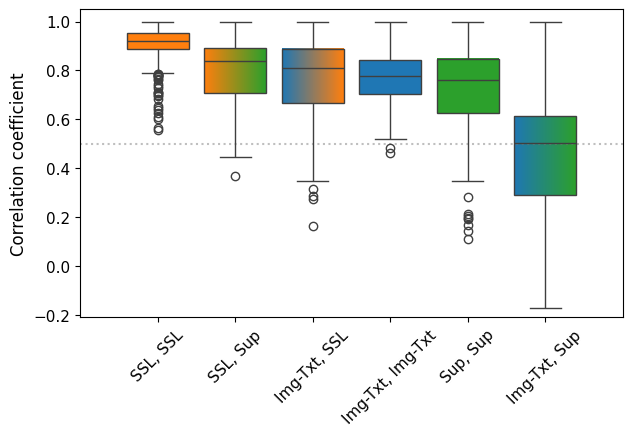

In [13]:
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(7, 4))
g = sns.boxplot(
    tmp,
    x='cat_pair',
    y='r coeff',
    order = sorting_order
)
g.tick_params(axis='x', which='major', labelsize=fontsizes['ticks'], rotation=45)
g.tick_params(axis='y', which='major', labelsize=fontsizes['ticks'])

for patch, color in zip(g.patches, colors):
    patch.set_facecolor('none')
    
    vertices = patch.get_path().vertices

    # Get box position and dimensions
    x = vertices[0, 0]  # left x position
    width = vertices[2, 0] - x  # width of the box
    y_bottom = vertices[1, 1]  # bottom of the box
    y_top = vertices[2, 1]  # top of the box
    height = y_top - y_bottom  # height of the box

    cmap = LinearSegmentedColormap.from_list('gradient', [color[0], color[1]])

    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    g.imshow(gradient, aspect='auto', cmap=cmap, 
              extent=(x, x + width, y_bottom, y_top), zorder=-1)

g.set_xlim(-1, len(colors))
g.set_ylim(-0.21, 1.05)  
g.set_xlabel('')
g.set_ylabel('Correlation coefficient', fontsize=fontsizes['label'])
g.axhline(0.5, c='grey', ls=':', alpha=0.5, zorder=-1)

In [133]:
len(g.patches), g.patches[0].get_path().vertices

(6,
 array([[-0.4       ,  0.88651181],
        [ 0.4       ,  0.88651181],
        [ 0.4       ,  0.95131786],
        [-0.4       ,  0.95131786],
        [-0.4       ,  0.88651181],
        [-0.4       ,  0.88651181]]))

In [ ]:
sim_cat = product(
    sorted(model_categories),
    list(sim_mats.keys())
)

for desired_cat, sim_metric in sim_cat:
    df_r_coeffs = corr_data[f"{desired_cat}_{sim_metric}"]
    fig = get_distribution_plot(df_r_coeffs)
    sm_name = sim_metric.replace(" ", "_").lower()
    save_or_show(fig,
                 storing_path / f'dist_r_coeff_cat_anchor_{desired_cat}_{sm_name}.pdf',
                 SAVE)
    break